In [1]:
import sys
import os
import importlib

import numpy as np
import scipy
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import pyemma
import mdtraj as md

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

%config InlineBackend.figure_format = "retina"

# Load data

In [11]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")

# committors
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)
qm_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qm_downup_3.npy", allow_pickle=True)
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0]

## States

In [5]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [6]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

# Rates

In [7]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]

In [8]:
d_down_arr = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/dist_down_3.npy")
d_up_arr = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/dist_up_3.npy")
print(d_down_arr.shape, d_up_arr.shape)

(4150115, 1) (4150115, 1)


In [9]:
in_Ac = np.split((~down_ids).astype(float), traj_inds)
in_B = np.split(up_ids.astype(float), traj_inds)
# d_A / (d_A + d_B)
dist_ratio = np.split(np.squeeze(d_down_arr / (d_up_arr + d_down_arr)), traj_inds)
# 1_{d_A > d_B}
da_ge_db = np.split(np.squeeze(d_down_arr > d_up_arr), traj_inds)
# use from lag 500
qm_rc = [(1 - qm) for qm in qm_du[8]]

In [14]:
def lag_weights(weights, lag):
    result = []
    for w in weights:
        w[len(w) - lag :] = 0
        result.append(w)
    return result

In [15]:
n_lags = len(lags)
rates_lags = np.zeros((n_lags, 6, n_lags))
rcs = [qp_du[6], qm_rc, in_B, in_Ac, dist_ratio, da_ge_db]

for i, (qp, qm) in enumerate(zip(qp_du, qm_du)):
    for j, rc in enumerate(rcs):
        for k, lag in enumerate(lags):
            print(f"Computing rates for committor lag {lags[j]}, and RC {k} rate lag {lag}...")
            com = lag_weights(weights, lag)
            rates_lags[i, j, k] = extq.tpt.rate(qp, qm, com, in_domain, rc, lag)

Computing rates for committor lag 1, and RC 0 rate lag 1...
Computing rates for committor lag 1, and RC 1 rate lag 2...
Computing rates for committor lag 1, and RC 2 rate lag 5...
Computing rates for committor lag 1, and RC 3 rate lag 10...
Computing rates for committor lag 1, and RC 4 rate lag 20...
Computing rates for committor lag 1, and RC 5 rate lag 50...
Computing rates for committor lag 1, and RC 6 rate lag 100...
Computing rates for committor lag 1, and RC 7 rate lag 200...
Computing rates for committor lag 1, and RC 8 rate lag 500...
Computing rates for committor lag 1, and RC 9 rate lag 1000...
Computing rates for committor lag 1, and RC 10 rate lag 2000...
Computing rates for committor lag 1, and RC 11 rate lag 3000...
Computing rates for committor lag 1, and RC 12 rate lag 4000...
Computing rates for committor lag 1, and RC 13 rate lag 5000...
Computing rates for committor lag 2, and RC 0 rate lag 1...
Computing rates for committor lag 2, and RC 1 rate lag 2...
Computing ra

/scratch/local/jobs/4690200/ipykernel_4111320/142602548.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()


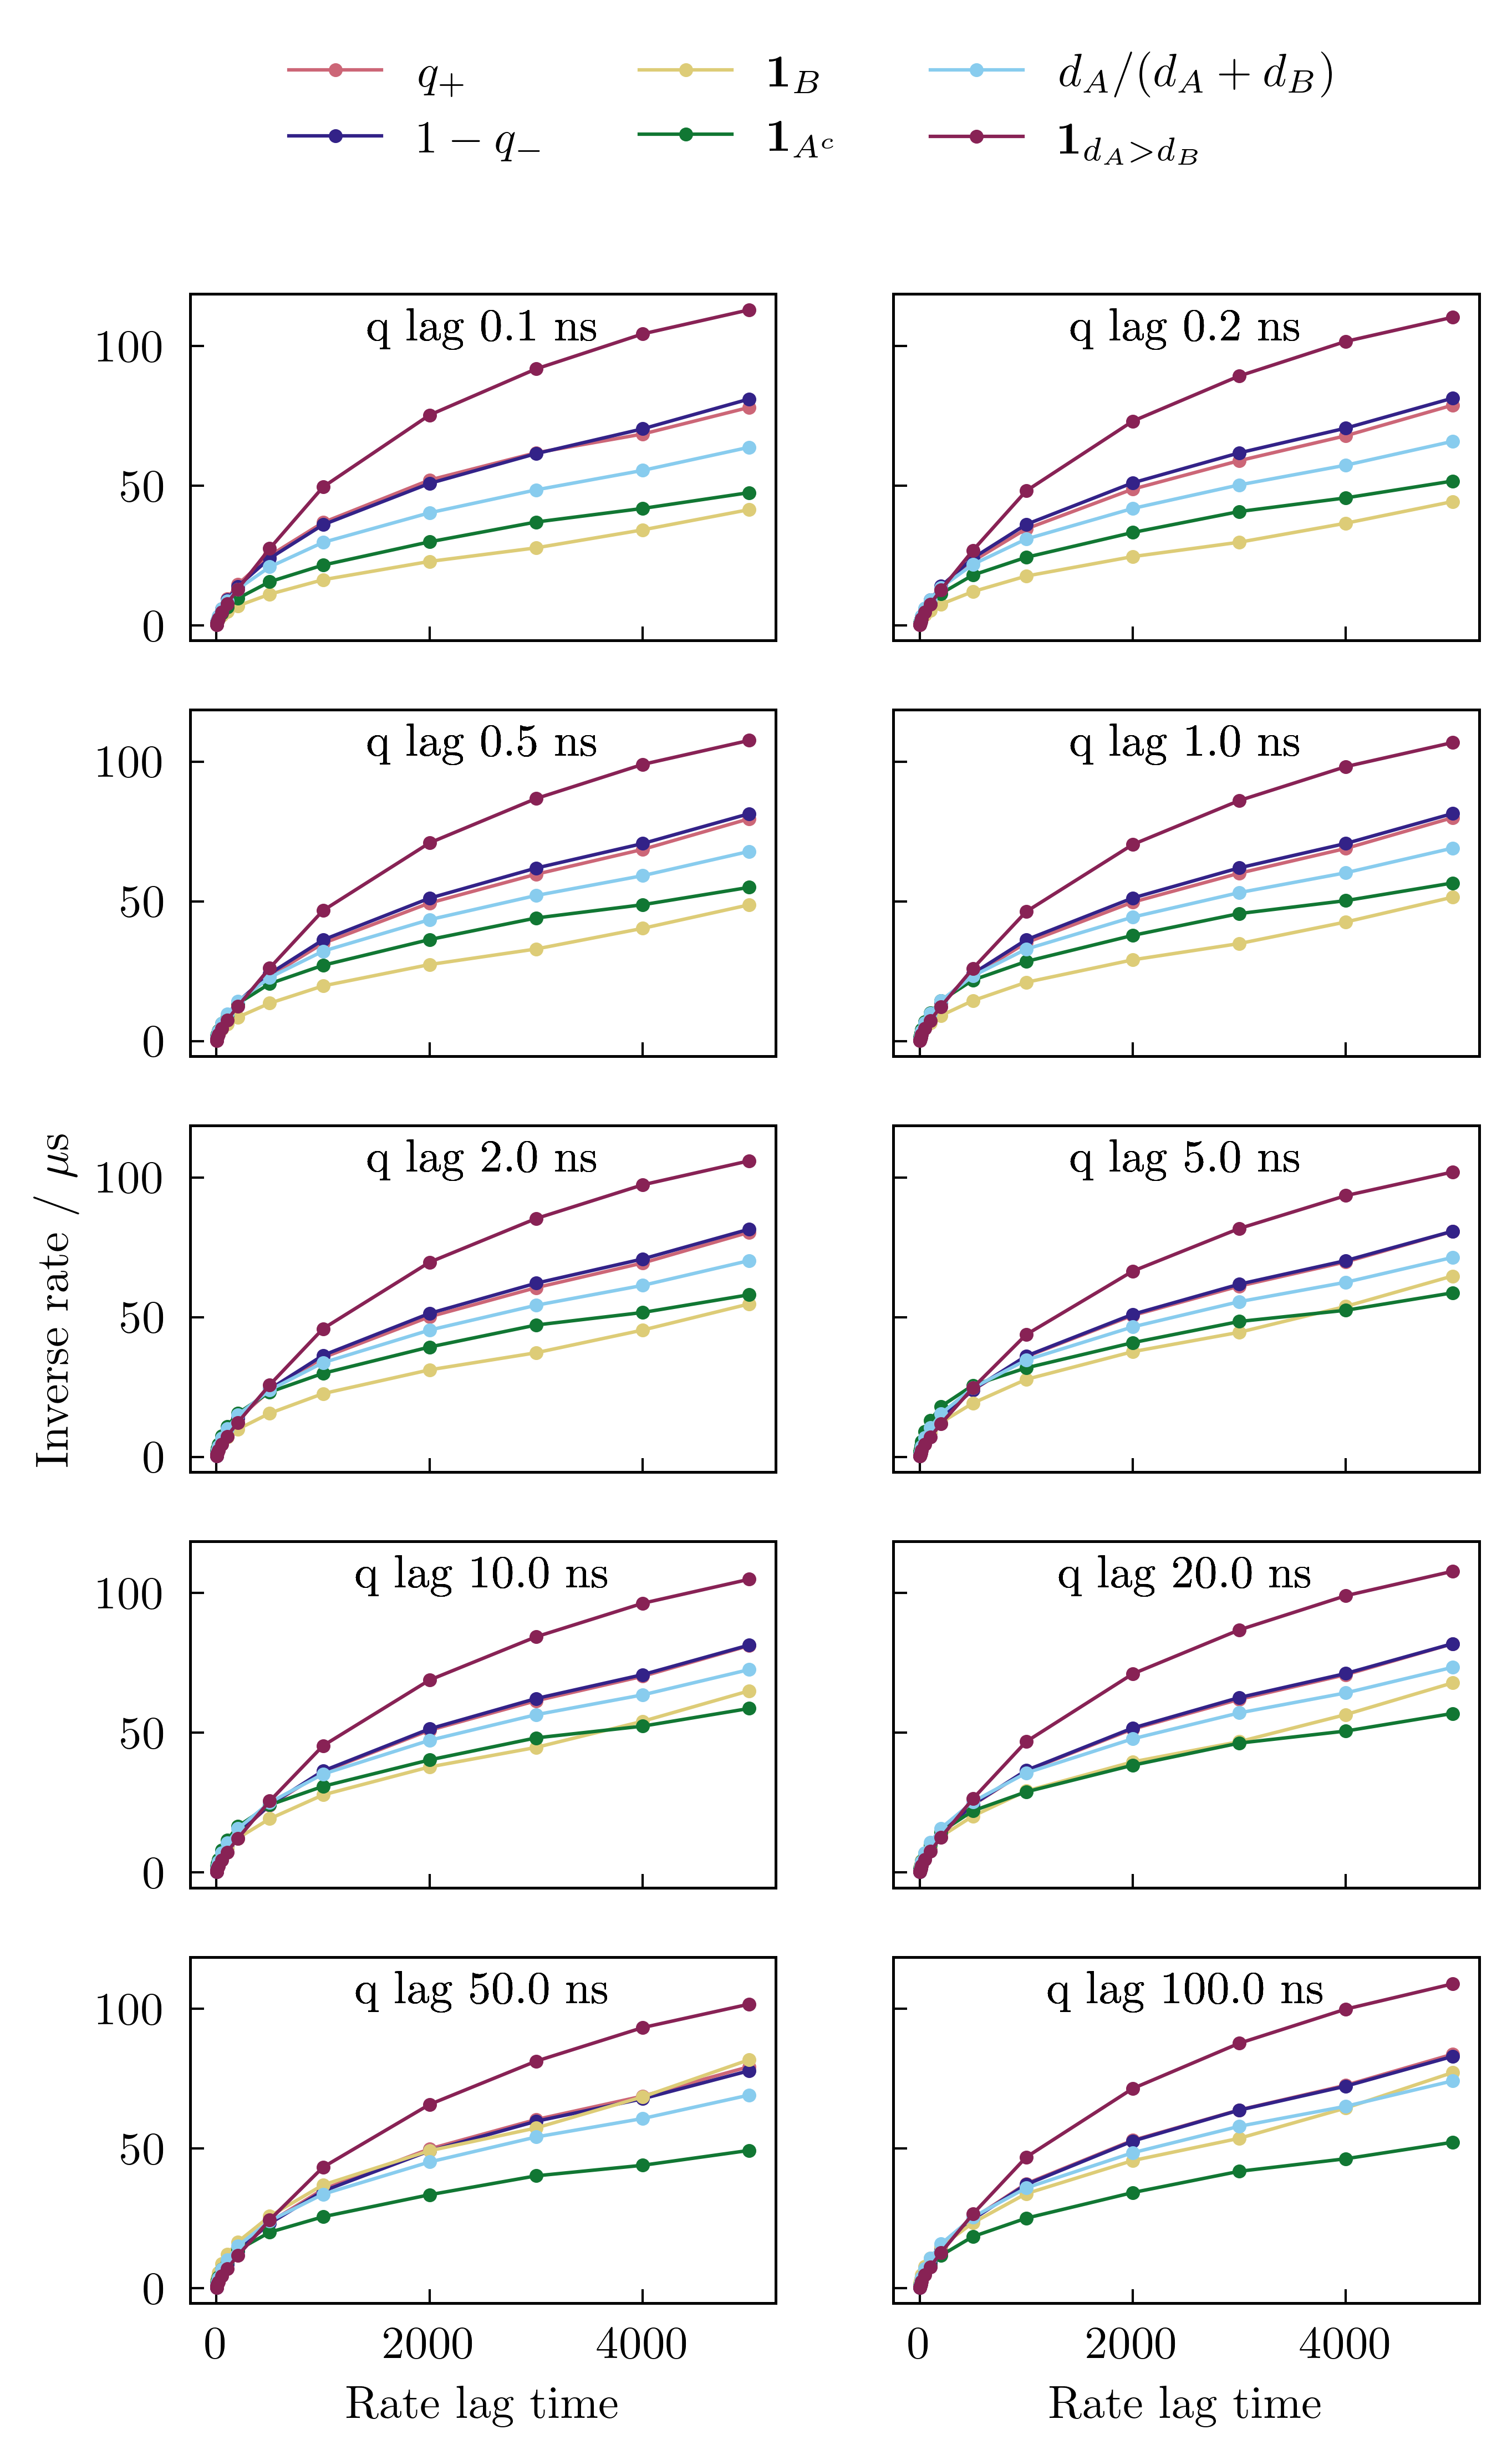

In [18]:
f, axs = plt.subplots(5, 2, figsize=(5, 8), dpi=300, sharex=True, sharey=True)
lagtimes = np.asarray(lags)
for i, ax in enumerate(axs.flat):
    for r in rates_lags[i]:
        # time steps in 0.1 ns
        ax.plot(lagtimes, 1 / r * 0.0001, 'o-')
        pplt.text(0.5, 0.9, f"q lag {lags[i] * 0.1} ns", transform=ax.transAxes)
    ax.set_xlabel("Rate lag time")
    ax.label_outer()
axs[2, 0].set_ylabel("Inverse rate / $\mu$s")
f.legend(
    ['$q_+$', 
    '$1 - q_-$',
    r'$\mathbf{1}_B$',
    r'$\mathbf{1}_{A^c}$',
    '$d_A / (d_A + d_B)$',
    r'$\mathbf{1}_{d_A > d_B}$'], loc='center', ncol=3, bbox_to_anchor=[0.5, 0.95])
f.tight_layout()

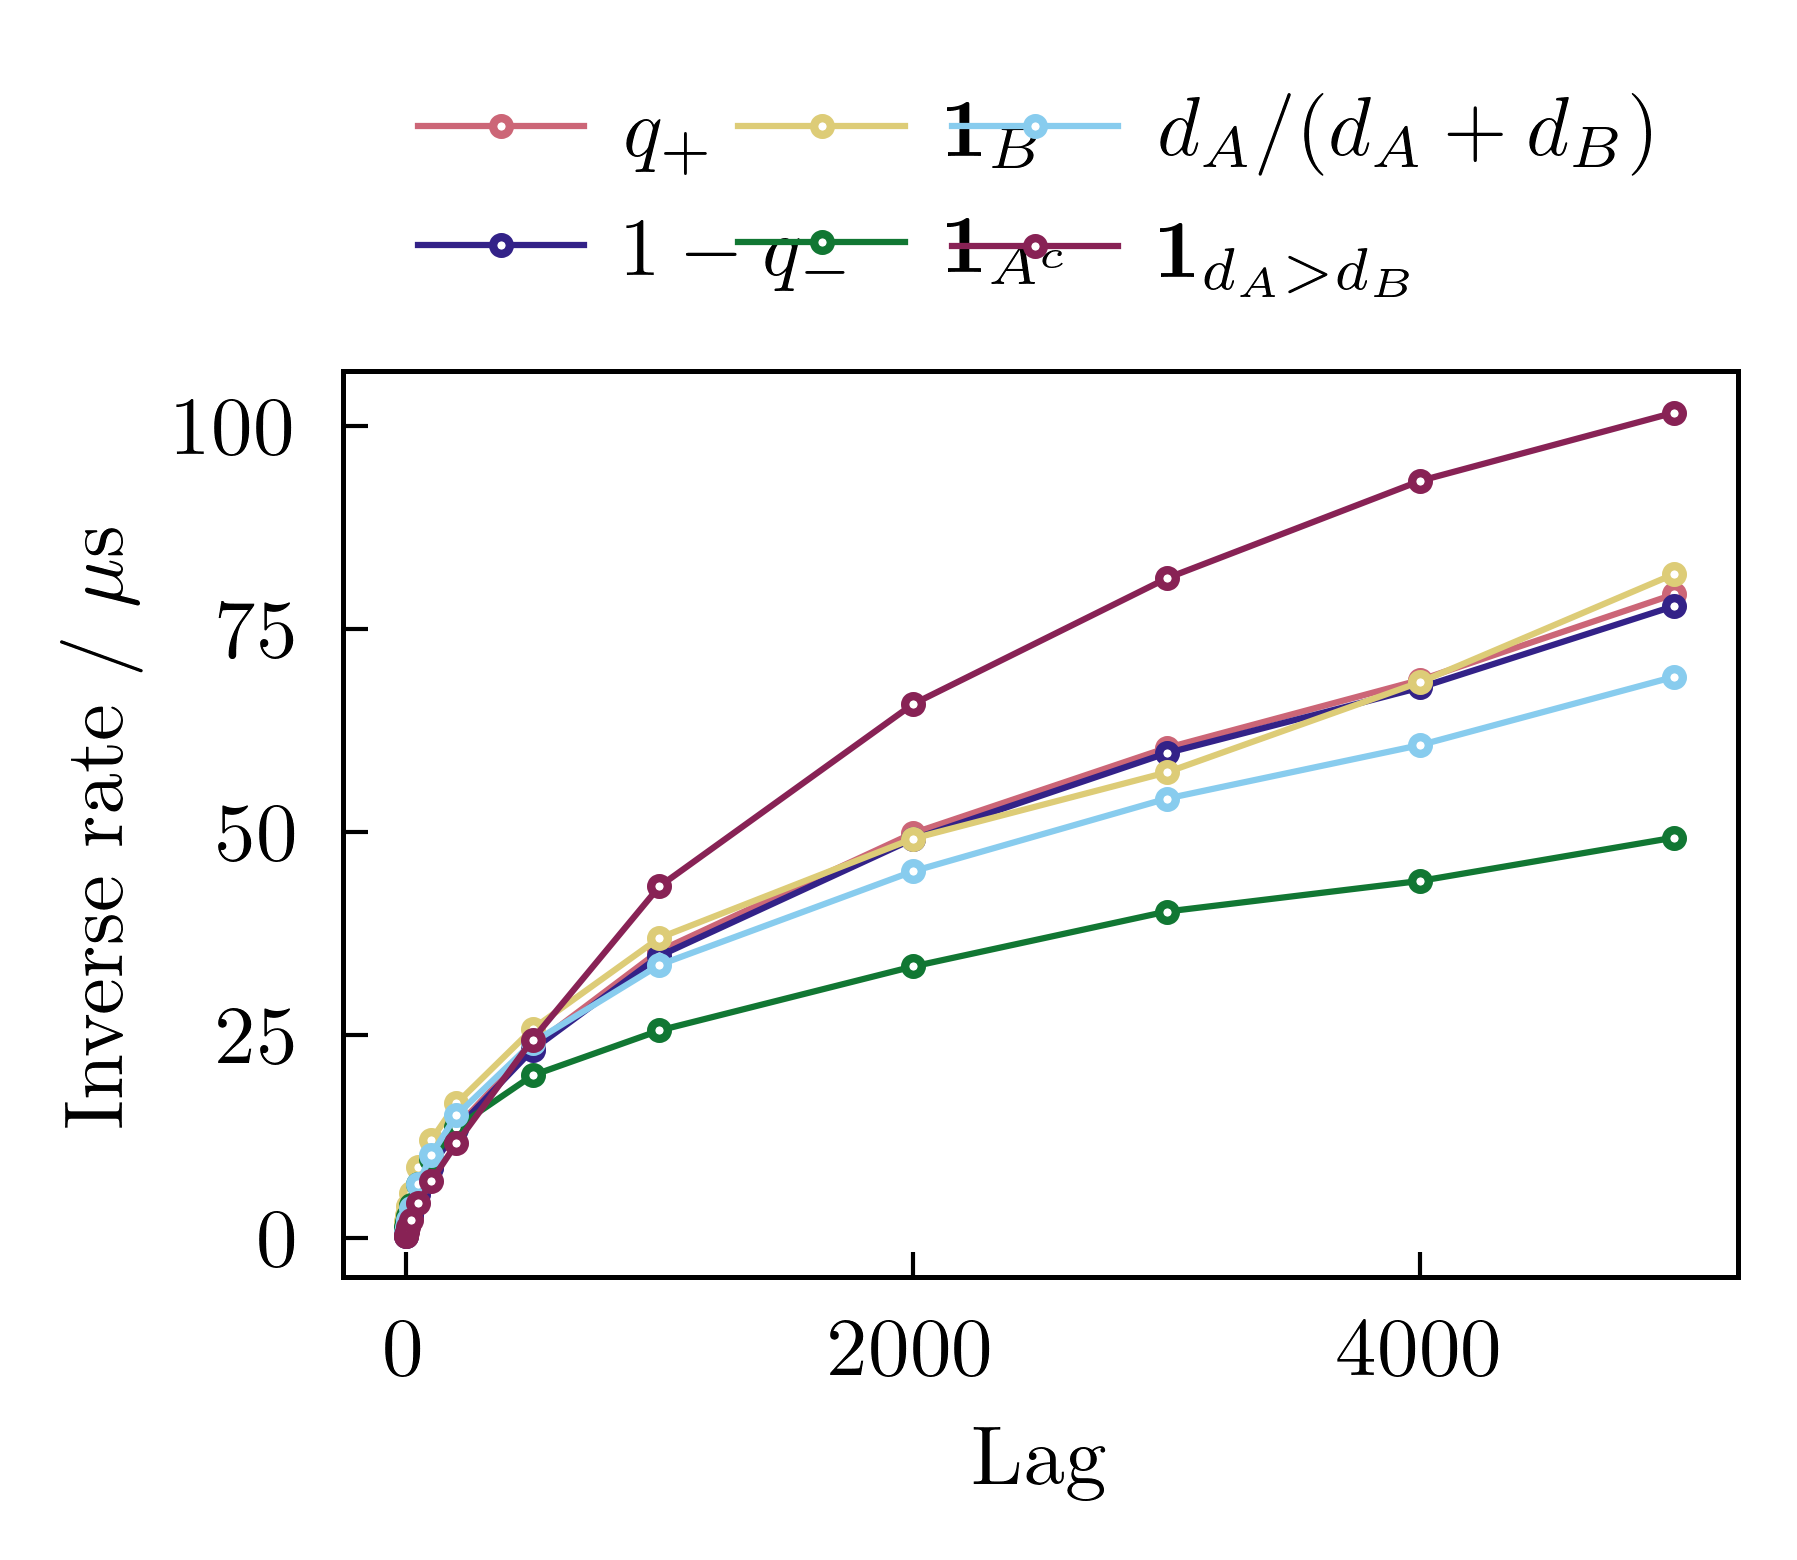

In [19]:
f = plt.figure(figsize=(3, 2), dpi=300)
ax = plt.gca()
lagtimes = np.asarray(lags)
# best looks like q of 50 ns
labels = [
    '$q_+$', 
    '$1 - q_-$',
    r'$\mathbf{1}_B$',
    r'$\mathbf{1}_{A^c}$',
    '$d_A / (d_A + d_B)$',
    r'$\mathbf{1}_{d_A > d_B}$']

for r, label in zip(rates_lags[8], labels):
    # time steps in 0.1 ns
    ax.plot(lagtimes, 1 / r * 0.0001, 'o-', mfc='white', label=label)
    
ax.set_xlabel("Lag")
ax.set_ylabel("Inverse rate / $\mu$s")
# ax.semilogy()
pplt.legend(outside='top', ncol=3, ax=ax, handletextpad=0.5)

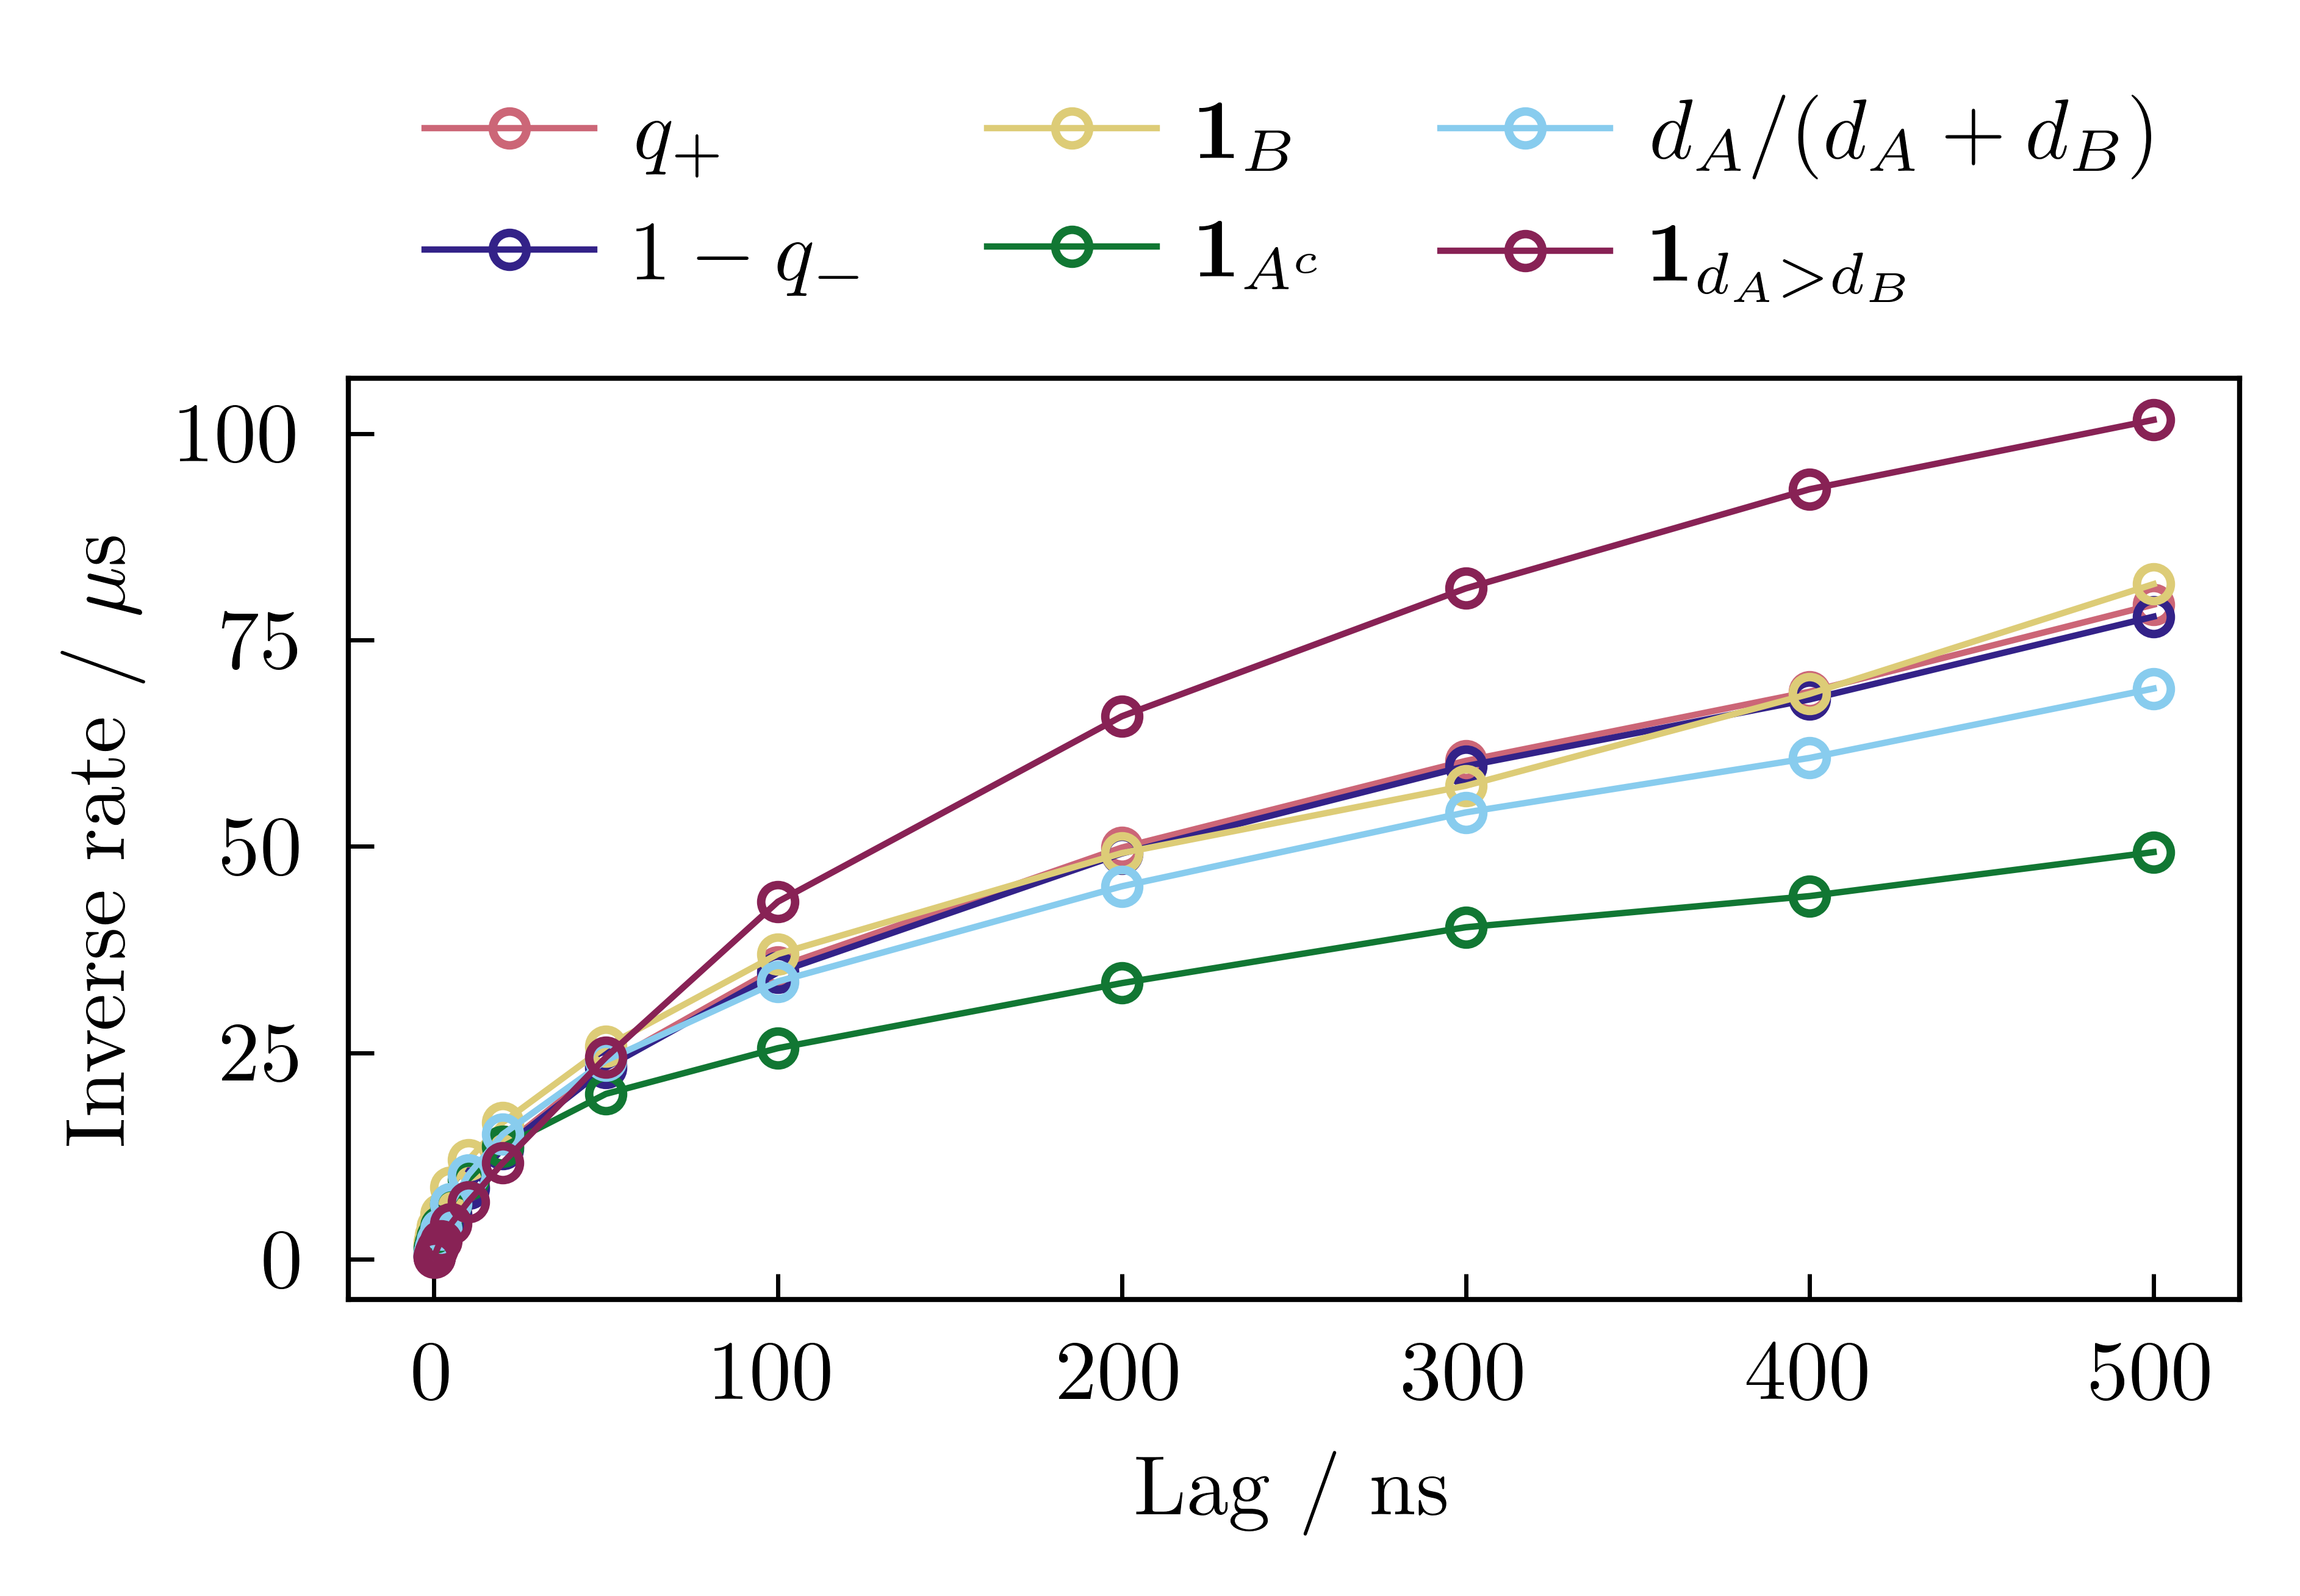

In [24]:
f = plt.figure(figsize=(4, 2), dpi=500)
ax = plt.gca()
lagtimes = np.asarray(lags) * 0.1
# best looks like q of 50 ns
labels = [
    '$q_+$', 
    '$1 - q_-$',
    r'$\mathbf{1}_B$',
    r'$\mathbf{1}_{A^c}$',
    '$d_A / (d_A + d_B)$',
    r'$\mathbf{1}_{d_A > d_B}$']

for r, label in zip(rates_lags[8], labels):
    # time steps in 0.1 ns
    ax.plot(lagtimes, 1 / r * 0.0001, 'o-', mfc='none', ms=4, label=label)
    
ax.set_xlabel("Lag / ns")
ax.set_ylabel("Inverse rate / $\mu$s")
# ax.semilogy()
pplt.legend(outside='top', ncol=3, ax=ax, handletextpad=0.5)
plt.savefig("../../fig/paper/rates.svg")

# MFPT

In [85]:
guess_max = 400000 # 40 us / 0.1 ns timestep
# guess_mfpt = guess_max * (1 - np.concatenate(qp_du[6]))
max_dist = np.max(d_up_arr)
guess_mfpt = guess_max * (np.squeeze(d_up_arr) / max_dist)
guess_mfpt[up_ids] = 0
guess_mfpt = np.split(guess_mfpt, traj_inds)

In [64]:
import random
random.seed(123)
N = len(cv_arr)
skip = 20
inds = random.sample(range(N), N // skip)

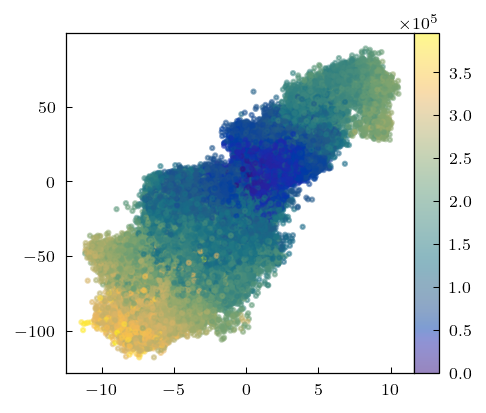

In [86]:
sc = plt.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=np.concatenate(guess_mfpt)[inds], cmap='macaw', alpha=0.5)
pplt.colorbar(sc)

In [75]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make smoothing 0 in D^c (up state for MFPT)
smooth[up_ids] = 0

basisF_arr = smooth * sb_arr
basisF = []
curr = 0
traj_lens = [len(traj) for traj in cv_trajs]
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

basis_d = util.orthogonalize(basisF, weights[0])

In [80]:
assert np.all(np.concatenate(basis_d)[up_ids] == 0)

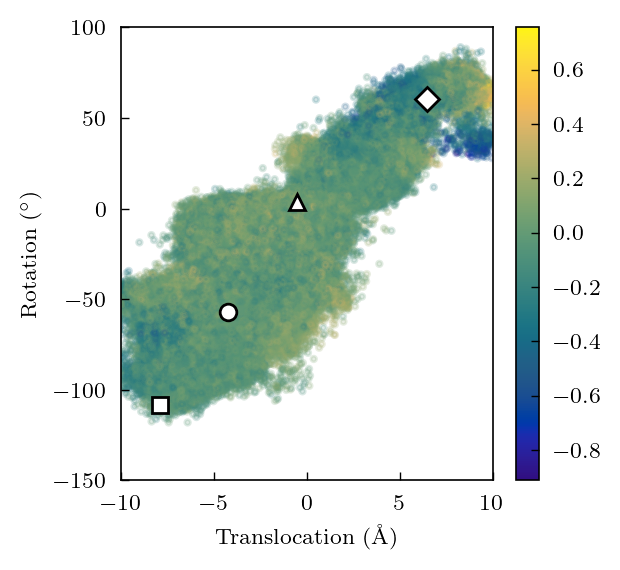

In [88]:
# Plot basis function
fig, ax = plt.subplots(dpi=200)
h = ax.scatter(
    cv_arr[inds, 0],
    cv_arr[inds, 1],
    c=np.mean(np.concatenate(basis_d), axis=-1)[inds],
    alpha=0.2,
    cmap='macaw',
)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

In [87]:
mfpt = []
in_D = np.split(up_ids, traj_inds)
for lag, com in zip(lags, weights):
    print(lag)
    mfpt.append(extq.dga.forward_mfpt(basis_d, com, in_D, guess_mfpt, lag))

1


LinAlgError: Matrix is singular.